**Summary**

In this tutorial we will enrich Beluga whale observations with bathymetry information. Or Acropora digitifera if you don't have a GBIF account and want to use the included occurrence dataset.

You will first prepare the dataset to be enriched.
It can be your own DarwinCore archive, or you can download one from GBIF.
An enrichment file will be created where data will be added later on.

Afterwards, you can pick a variable id from the [catalog file](geoenrich/catalog.csv). If the variable you want is not available, feel free to update the *catalog.csv* file with new rows (see [installation instructions](https://geoenrich.readthedocs.io/en/latest/install.html)).


# Download from GBIF

In [ ]:
from geoenrich.biodiv import *

#### Get GBIF id for the taxon of interest

In [ ]:
taxKey = get_taxon_key('Delphinapterus leucas')

#### Request an archive with all occurrences of this taxon

In [ ]:
request_id = request_from_gbif(taxKey)

#### Download request

For large requests, some waiting time is needed for the archive to be ready.

In [ ]:
download_requested(request_key = request_id)

# Load occurrence data and create enrichment file

In [ ]:
import os
import geoenrich
from geoenrich.biodiv import *
from geoenrich.enrichment import create_enrichment_file

#### If data was downloaded from gbif

In [ ]:
geodf = open_dwca(taxonKey = taxKey)

#### If you are using your own dataset (DarwinCore format)

In [ ]:
# NB: A DarwinCore archive is bundled into the package for user testing.
# If you don't have a dataset and you don't want to register to GBIF yet you can use this one.

example_path = os.path.split(geoenrich.__file__)[0] + '/data/AcDigitifera.zip'
geodf = open_dwca(path = example_path)

#### If you are using your own dataset (csv format)

In [ ]:
# Fill in the path to your csv and the compulsory column names.
# Additional arguments are passed down to pandas.read_csv

geodf = import_csv(path = '', id_col = '', date_col = '', lat_col = '',
                           lon_col = '', depth_col = '')

#### Create enrichment file

In [ ]:
dataset_ref = 'your_dataset_name'
create_enrichment_file(geodf, 'your_dataset_name')

# Enrich

In [ ]:
from geoenrich.enrichment import enrich

#### Define enrichment scope

In [ ]:
var_id = 'bathymetry'
dataset_ref = 'your_dataset_name'

geo_buff = 115       # kilometers
time_buff = (-7, 0)  # Download data from 7 days before occurrence date to occurrence date
                     # (for datasets where time is a dimension)

#### Enrich

Only enrich a small slice first to check speed.

In [12]:
enrich(dataset_ref, var_id, geo_buff, time_buff, slice = (0, 100))

311 occurrences were loaded from enrichment file


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 922.94it/s]

Enrichment over


# Data retrieval

In [13]:
from geoenrich.enrichment import enrichment_status, read_ids, retrieve_data

dataset_ref = 'your_dataset_name'

#### Check the enrichment status of the dataset.

In [14]:
enrichment_status(dataset_ref)

,bathymetry
Enriched,100
Not enriched,211
Data not available,0



#### Request data from local storage for the first row of our dataset.

In [21]:
ids = read_ids(dataset_ref)
occ_id = ids[0]
output = retrieve_data(dataset_ref, occ_id, shape = 'buffer')

#### Unpack and plot data

In [22]:
var_id = 'bathymetry'

data = output[var_id]['values']
unit = output[var_id]['unit']
coords = output[var_id]['coords']

<IPython.core.display.Javascript object>


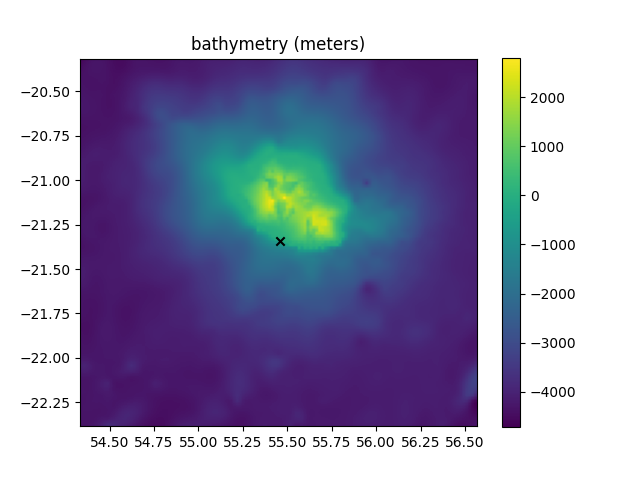

In [24]:
from shapely import wkt
from matplotlib import pyplot as plt
%matplotlib notebook

# Get latitude and longitude values for the requested data
lat_dim = [c[0] for c in coords].index('latitude')
lon_dim = [c[0] for c in coords].index('longitude')
lats = coords[lat_dim][1]
longs = coords[lon_dim][1]

# Get coordinates for the occurrence point
filepath = biodiv_path + dataset_ref + '.csv'
df = pd.read_csv(filepath, parse_dates = ['eventDate'], infer_datetime_format = True, index_col = 0)
point = wkt.loads(df.loc[occ_id, 'geometry'])

# Plot
extent = [longs[0] , longs[-1], lats[0] , lats[-1]]
plt.imshow(data, extent = extent, origin = 'lower')
plt.title(var_id + ' (' + unit + ')')
plt.colorbar()
plt.scatter([point.x], [point.y], c='black', marker='x')

# NB: If your data has time or depth dimensions, you will have to pick a slice of the data array to be able to plot it